## This scripts are used to test the computing clustering pipeline

In [1]:
import os
os.environ["MPICH_GPU_SUPPORT_ENABLED"] = "0"
import sys
import random
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,join,Column

from cosmoprimo.fiducial import DESI, AbacusSummit
from pycorr import TwoPointCorrelationFunction, setup_logging
from pycorr.corrfunc import CorrfuncTwoPointCounter
from pypower import CatalogFFTPower, PowerSpectrumMultipoles, setup_logging
from pycorr import project_to_multipoles, project_to_wp, TwoPointCorrelationFunction, setup_logging
setup_logging()

sys.path.append('/global/homes/s/shengyu/desi_y3_redshift_errors/main/')
from helper import REDSHIFT_BIN_OVERALL, REDSHIFT_BIN_LSS, REDSHIFT_ABACUSHF_v1, NRAN, TRACER_CUTSKY_INFO
from helper import GET_REPEATS_DV, GET_CTHR, GET_REPEATS_NUMBER
from cat_tools import read_positions_weights, get_proposed_mattrs
from fitting_tools import load_bins

BASE_DIR = '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1'
REPEAT_DIR = '/pscratch/sd/s/shengyu/repeats/DA2/loa-v1'

def zfmt(x):
    return f"{x:.3f}".replace(".", "p")

cosmo = DESI()
BOXSIZE = 2000
NSPLITS = 10
ells = (0, 2, 4)
kedges   = np.arange(0.,0.4001,0.001) # for PK
smuedges  = (np.linspace(0., 200, 201), np.linspace(-1., 1., 201)) # for 2PCF
slogedges= (np.geomspace(0.01, 100., 100), np.linspace(-1., 1., 201)) # for small scale 2PCF
rlogedges = (np.geomspace(0.01, 100., 100), np.linspace(-1., 1., 201)) # for Projected CF

rmin, rmax, rbin, lenr = load_bins('xi')
kmin, kmax, kbin, lenk = load_bins('pk')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


## Check for the cutsky mocks

In [3]:
# load the data
tracer = 'LRG'
indz = 0
z = REDSHIFT_ABACUSHF_v1[tracer][indz]
(zmin, zmax) = REDSHIFT_BIN_LSS[tracer][indz]
mock_id = '000'
fit_range = TRACER_CUTSKY_INFO[tracer]['fit_range']
cutsky_name = f'cutsky_abacusHF_DR2_{tracer}_z{zfmt(z)}_zcut_{fit_range}_clustering.dat.fits'
data_fn = BASE_DIR+ f'/Cutsky/{tracer}/z{z:.3f}/AbacusSummit_base_c000_ph{mock_id}/forclustering/'+cutsky_name
data = Table.read(data_fn)

data

RA,DEC,TRUEZ,STATUS,RAW_NZ,RAN_NUM_0_1,NZ,Z,HALO_ID,HALO_MASS,IS_CENTRAL,WEIGHT,DESI_TARGET,PRIORITY_INIT,PRIORITY,NUMOBS_MORE,NUMOBS_INIT,BGS_TARGET,TARGETID,MWS_TARGET,SUBPRIORITY,BRICKNAME,OBSCONDITIONS,SCND_TARGET,ZWARN,Z_OBS_GLOBAL,Z_OBS_BIN
float32,float32,float32,int32,float32,float32,float32,float32,int64,float32,bool,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,bytes8,int64,int64,int64,float64,float32
67.279564,1.3355781,0.39637807,35,0.0008973729,0.25898218,0.00055419706,0.40078488,35108400021002000,88636260000000.0,False,1.0,1,3200,3200,2,2,0,100605093,0,0.25138016107328864,000p0000,1,0,0,0.4003638965380678,0.40083435
68.66768,-1.3406755,0.39677155,43,0.0008973729,0.589913,0.00055403064,0.4000821,33108491679000000,16505672000000.0,True,1.0,1,3200,3200,2,2,0,100605357,0,0.618578574508813,000p0000,1,0,0,0.4002581636716288,0.3999677
67.66313,-2.0999813,0.39656883,43,0.0008973729,0.5170204,0.0005541164,0.40084955,34608431667000000,4815033000000.0,True,1.0,1,3200,3200,2,2,0,100605445,0,0.9796655831546774,000p0000,1,0,0,0.400348500720795,0.4009324
67.68721,-2.1535735,0.3973315,43,0.0008973729,0.52478796,0.0005537938,0.4002595,34608441666000000,23231533000000.0,True,1.0,1,3200,3200,2,2,0,100605446,0,0.6230454990014297,000p0000,1,0,0,0.4002013878314199,0.40007097
63.55028,-7.9907236,0.39719322,43,0.0008973729,0.10918018,0.00055385224,0.40031442,40208091573000000,12089255000000.0,True,1.0,1,3200,3200,2,2,0,100605687,0,0.8821976397740235,000p0000,1,0,0,0.4005890922543373,0.40032828
62.30003,-8.652832,0.39629152,43,0.0008973729,0.0055214786,0.0005542337,0.40041435,41807981563001000,4855105600000.0,True,1.0,1,3200,3200,2,2,0,100605747,0,0.9427858483108079,000p0000,1,0,0,0.40028086106279404,0.4002968
67.13799,-2.6625009,0.39558944,43,0.0008973729,0.15657638,0.00055453065,0.40065953,35208381658001000,25119160000000.0,False,1.0,1,3200,3200,2,2,0,100605834,0,0.1680181124386757,000p0000,1,0,0,0.4007759155757244,0.40057698
65.31822,-18.70759,0.3926182,43,0.0008973729,0.42452627,0.0005548824,0.4002996,35607781409004000,195235570000000.0,False,1.0,1,3200,3200,2,2,0,100605837,0,0.11786224927941535,000p0000,1,0,0,0.40058393497578965,0.40037975
62.722187,-2.6784344,0.39696732,43,0.0008973729,0.59677297,0.0005539478,0.4010977,41608091658000000,254798150000000.0,False,1.0,1,3200,3200,2,2,0,100605863,0,0.07782714515781886,000p0000,1,0,0,0.4009686133035782,0.40129104


In [3]:
# load the randoms, random length 32943255

ran_dir = '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/random'

ran_mock_fns = [ran_dir+f'/rands_intiles_DARK_{i}_NO_imagingmask_withz.ran.fits'.format(i) for i in range(8, 8+NRAN[tracer])]

print(ran_mock_fns)

ran = Table.read(ran_mock_fns[0])

ran

['/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/random/rands_intiles_DARK_8_NO_imagingmask_withz.ran.fits', '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/random/rands_intiles_DARK_9_NO_imagingmask_withz.ran.fits', '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/random/rands_intiles_DARK_10_NO_imagingmask_withz.ran.fits', '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/random/rands_intiles_DARK_11_NO_imagingmask_withz.ran.fits']


RA,DEC,BRICKNAME,BRICKID,NOBS_G,NOBS_R,NOBS_Z,MASKBITS,Z_LRG,WEIGHT,Z_QSO,Z_ELG_LOP,ELG_LOP_MASK
float64,float64,bytes8,int32,int16,int16,int16,int16,float32,float64,float32,float32,bool
263.26957003127893,50.872682195728345,2633p507,587330,3,3,3,2048,0.5953857,1.0,1.5727819,1.1928512,True
257.4066951972251,43.350162955066544,2575p432,557802,3,3,4,0,0.89293617,1.0,1.7004937,1.0900215,True
256.6798214561534,49.80916807106869,2565p497,583619,3,3,5,0,0.48213458,1.0,1.8297571,1.5042626,True
124.93772536522738,51.04988329310739,1248p510,587891,5,4,4,0,0.9130829,1.0,2.3258562,0.90918016,True
171.44139936546492,34.5718040718846,1713p345,518242,3,3,3,0,0.75911355,1.0,1.6073139,1.4200398,True
272.6958568331494,35.546143848351754,2726p355,523302,2,2,3,0,0.58966184,1.0,2.3628173,1.0121537,True
111.40301311591142,36.560228671112824,1112p365,527450,3,5,4,0,0.9274481,1.0,0.91393113,1.0414948,True
135.51270356764292,46.67220276022892,1354p467,571754,4,3,2,0,0.6895867,1.0,1.6632545,0.8989633,True
222.70830329842923,43.95252627675806,2227p440,560837,3,3,1,0,0.7841586,1.0,1.8262196,1.4543241,True


## Check the 2pt computing codes

In [ ]:
tracer = 'QSO'
indz = 0
data_args = {'tracer':tracer, 'indz': indz, 'mock_id03': '000', 'mock_dir':'000', 'domain':'cutsky'}

data_positions, _ = read_positions_weights(data_args, use_zerr=None)
# positions1, _ = read_positions_weights(data_args, use_zerr='global')
# positions2, _ = read_positions_weights(data_args, use_zerr='bin')

In [27]:
data_positions.T[::10].T.shape

(3, 270102)

In [3]:
random_positions_all, _ = read_positions_weights(data_args, use_random=True)

In [ ]:
dat_pos = data_positions.T[::10].T.shape
ran_pos = random_positions_all.T[::10].T

In [ ]:
NSPLITS = 1

# load the randoms
cosmo = DESI()

result = 0
D1D2 = None
R1R2 = None

#_void_ran = [np.array_split(v, NSPLITS)[i] for v in void_ran]
#_void_ran[2] = cosmo.comoving_radial_distance(_void_ran[2])
# if rr_dir is not None:
    # RR_local_fn = rr_dir+f'/RR/RRparis_{tracer}_{region}_z{zmin}-{zmax}_split{i}.npy'
    # R1R2 = CorrfuncTwoPointCounter.load(RR_local_fn) if os.path.exists(RR_local_fn) else None
result = TwoPointCorrelationFunction('smu', smuedges, 
                                data_positions1=dat_pos, data_weights1=None,
                                randoms_positions1=ran_pos, randoms_weights1=None,
                                engine='corrfunc', position_type = 'rdd', #los = 'firstpoint',
                                D1D2 = D1D2, R1R2 = R1R2,
                                gpu=True, 
                                nthreads = 60)

#     if rr_dir is not None:
#         if not os.path.exists(RR_local_fn): 
#             R1R2 = local_result.R1R2
#             R1R2.save(RR_local_fn)
    
# if rr_dir is not None:
#     RR_fn = rr_dir+f'/RR/RRparis_{tracer}_{region}_z{zmin}-{zmax}.npy'
#     if not os.path.exists(RR_fn):
#         R1R2 = result.R1R2
#         R1R2.save(RR_fn)

# D1D2 = result.D1D2
result.save('./tests/tpcf_test_cutsky')

[001048.25]  11-21 07:18  TwoPointCorrelationFunction  INFO     Using estimator <class 'pycorr.twopoint_estimator.LandySzalayTwoPointEstimator'>.
[001048.25]  11-21 07:18  TwoPointCorrelationFunction  INFO     Running auto-correlation.
[001048.25]  11-21 07:18  TwoPointCorrelationFunction  INFO     Computing two-point counts D1D2.


[001049.38]  11-21 07:18  TwoPointCorrelationFunction  INFO     Computing two-point counts D1R2.
[001056.18]  11-21 07:18  TwoPointCorrelationFunction  INFO     Computing two-point counts R1R2.
[001067.01]  11-21 07:18  TwoPointCorrelationFunction  INFO     Correlation function computed in elapsed time 18.76 s.
[001067.01]  11-21 07:18  LandySzalayTwoPointEstimator INFO     Saving ./tests/tpcf_test_cutsky.


In [ ]:
()

result = TwoPointCorrelationFunction.load('./tests/tpcf_test_cutsky.npy')
result = result[::rbin,::]
result = result.select((rmin, rmax))
r, xi = project_to_multipoles(result, ells=[0, 2])

[001081.67]  11-21 07:18  TwoPointEstimator            INFO     Loading ./tests/tpcf_test_cutsky.npy.


[001096.20]  11-21 07:18  TwoPointEstimator            INFO     Loading ./tests/tpcf_test_cutsky.npy.
[001096.22]  11-21 07:18  TwoPointEstimator            INFO     Loading /pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/QSO/z1.400/AbacusSummit_base_c000_ph000/mpspk/xipoles_QSO_zp1.400_DR2_v1.0.npy.
[001096.23]  11-21 07:18  TwoPointEstimator            INFO     Loading /pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/QSO/z1.400/AbacusSummit_base_c000_ph000/mpspk/xipoles_QSO_zp1.400_DR2_v1.0_dv_zobs0.8-2.1.npy.


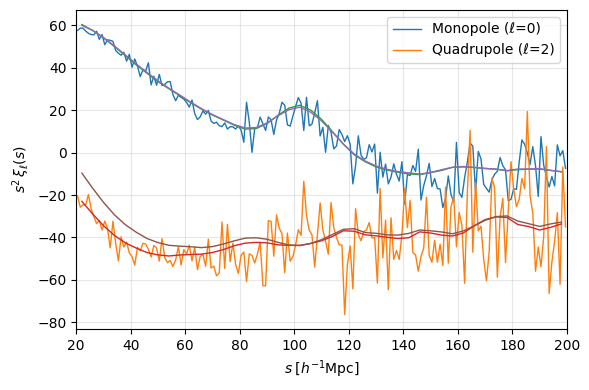

In [ ]:
# Load binning
rmin, rmax, rbin, lenr = load_bins('xi')

# Load result

# Rebin in r by selecting every rbin-th radial bin
result = TwoPointCorrelationFunction.load('./tests/tpcf_test_cutsky.npy')
# result = result[::rbin,::]
result = result.select((rmin, rmax))
r, xi = project_to_multipoles(result, ells=[0, 2])
plt.figure(figsize=(6,4))
plt.plot(r, r**2 * xi[0], lw=1, label='Monopole (ℓ=0)')
plt.plot(r, r**2 * xi[1], lw=1, label='Quadrupole (ℓ=2)')

base_dir = '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/QSO/z1.400/AbacusSummit_base_c000_ph000/mpspk'
fn = base_dir+'/xipoles_QSO_zp1.400_DR2_v1.0.npy'
result = TwoPointCorrelationFunction.load(fn)
result = result[::rbin,::]
result.select((rmin, rmax))
r, xi = project_to_multipoles(result, ells=[0,2])
plt.plot(r, r**2*xi[0], lw = 1)
plt.plot(r, r**2*xi[1], lw = 1)

base_dir = '/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/QSO/z1.400/AbacusSummit_base_c000_ph000/mpspk'
fn = base_dir+'/xipoles_QSO_zp1.400_DR2_v1.0_dv_zobs0.8-2.1.npy'
result = TwoPointCorrelationFunction.load(fn)
result = result[::rbin,::]
result.select((rmin, rmax))
r, xi = project_to_multipoles(result, ells=[0,2])
plt.plot(r, r**2*xi[0], lw = 1)
plt.plot(r, r**2*xi[1], lw = 1)

plt.xlabel(r"$s\;[h^{-1}{\rm Mpc}]$")
plt.ylabel(r"$s^2 \,\xi_\ell(s)$")
plt.xlim(rmin, rmax)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()

## Test the power spectrum computing codes

In [2]:
tracer = 'QSO'
indz = 0
data_args = {'tracer':tracer, 'indz': indz, 'mock_id03': '000', 'mock_dir':'000', 'domain':'cutsky'}
mat = get_proposed_mattrs(tracer)

data_positions, _ = read_positions_weights(data_args, use_zerr=None)
# positions1, _ = read_positions_weights(data_args, use_zerr='global')
# positions2, _ = read_positions_weights(data_args, use_zerr='bin')
random_positions_all, _ = read_positions_weights(data_args, use_random=True)

[LOAD]: /pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/QSO/z1.400/AbacusSummit_base_c000_ph000/forclustering/cutsky_abacusHF_DR2_QSO_z1p400_zcut_0p8to3p5_clustering.dat.fits
[LOAD]: /pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/random/rands_intiles_DARK_8_NO_imagingmask_withz.ran.fits


In [5]:
# dat_pos = data_positions
dat_pos = data_positions.T[::10].T
# ran_pos = random_positions_all
ran_pos = random_positions_all.T[::10].T

In [6]:
mat = get_proposed_mattrs(tracer)

In [9]:
result_pk = CatalogFFTPower(edges=kedges, ells=ells,
                            data_positions1=dat_pos, randoms_positions1=ran_pos,
                             position_type='rdd', resampler='tsc',
                            interlacing=3, boxsize = mat['boxsize'], cellsize = mat['cellsize'])
                            # mpiroot=mpiroot, mpicomm=mpicomm)
result_pk.save('./tests/pk_test_cutsky.npy')

[000005.73]  11-25 02:42  CatalogFFTPower              INFO     Painting catalog 1 to mesh CatalogMesh(nmesh=[1000 1000 1000], boxsize=[10000. 10000. 10000.], boxcenter=[ 1.76666947e-01 -1.90113856e+01  1.19384830e+03], dtype=float64).
[000009.06]  11-25 02:42  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 270102.
[000009.36]  11-25 02:42  CatalogMesh                  INFO     Painted 270102 out of 270102 objects to mesh.
[000009.40]  11-25 02:42  CatalogMesh                  INFO     Slab 0 ~ 4194304 / 9235281.
[000012.19]  11-25 02:42  CatalogMesh                  INFO     Painted 4194304 out of 9235281 objects to mesh.
[000012.19]  11-25 02:42  CatalogMesh                  INFO     Slab 4194304 ~ 8388608 / 9235281.
[000014.82]  11-25 02:42  CatalogMesh                  INFO     Painted 8388608 out of 9235281 objects to mesh.
[000014.82]  11-25 02:42  CatalogMesh                  INFO     Slab 8388608 ~ 12582912 / 9235281.
[000015.48]  11-25 02:42  CatalogMesh             

: 

In [ ]:
# Rebin in r by selecting every rbin-th radial bin
result = TwoPointCorrelationFunction.load('./tests/pk_test_cutsky.npy')
result = result.select((kmin,kmax,kbin))
pk = np.real(result.get_power())
k = result.kavg
plt.plot(k, k*pk[0], lw = 1)
plt.plot(k, k*pk[1], lw = 1)


[000154.05]  11-25 04:04  PowerSpectrumMultipoles      INFO     Loading /pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/QSO/z1.400/AbacusSummit_base_c000_ph000/forclustering/mpspk/pkpoles_QSO_zp1.400_DR2_v1.0.npy.
[0.02268204 0.02764907 0.03262953 0.03761292 0.04260007 0.04758946
 0.05258336 0.05757627 0.06256912 0.06756442 0.0725575  0.07755483
 0.08255304 0.08754968 0.09254586 0.09754292 0.10254236 0.10753957
 0.11253686 0.11753562 0.1225342  0.12753216 0.13253095 0.13752957
 0.14252756 0.14752836 0.15252884 0.15752723 0.16252556 0.16752447
 0.1725248  0.1775251  0.18252275 0.18752124 0.19252154 0.19752145
 0.20252079 0.20752038 0.21251983 0.21751936 0.22251928 0.22751907
 0.23251854 0.23751816 0.24251752 0.24751682 0.25251706 0.25751612
 0.26251633 0.26751619 0.27251474 0.27751502 0.2825152  0.28751456
 0.29251382 0.29751407]
[000154.07]  11-25 04:04  PowerSpectrumMultipoles      INFO     Loading /pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/QSO/z1.40

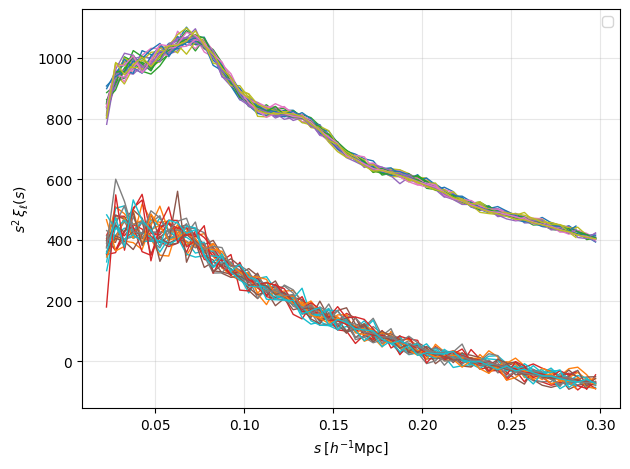

In [4]:
for id in range(20):
    id03 = f'{id:03}'
    result = PowerSpectrumMultipoles.load(f'/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Cutsky/QSO/z1.400/AbacusSummit_base_c000_ph{id03}/forclustering/mpspk/pkpoles_QSO_zp1.400_DR2_v1.0.npy')
    result = result.select((kmin,kmax,kbin))
    pk = np.real(result.get_power())
    k = result.kavg
    plt.plot(k, k*pk[0], lw = 1)
    plt.plot(k, k*pk[1], lw = 1)
    print(k)

for id in range(5):
    id03 = f'{id:03}'
    base_dir = f'/pscratch/sd/s/shengyu/galaxies/catalogs/Y3/AbacusHF-v1/Boxes/QSO/z1.400/AbacusSummit_base_c000_ph{id03}/mpspk'
    fn = base_dir+'/pkpoles_QSO_zp1.400_DR2_v1.0.npy'
    result = PowerSpectrumMultipoles.load(fn)
    result = result.select((kmin,kmax,kbin))
    pk = np.real(result.get_power())
    k = result.kavg
    plt.plot(k, k*pk[0], lw = 1)
    plt.plot(k, k*pk[1], lw = 1)

plt.xlabel(r"$s\;[h^{-1}{\rm Mpc}]$")
plt.ylabel(r"$s^2 \,\xi_\ell(s)$")
# plt.xlim(rmin, rmax)
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()